This notebook gives a quick tour of running the EpidemicRL julia code from python and does some preliminary experiments with the REINFORCE policy gradient algorithm.

In [1]:
from julia.api import Julia
# Disable the compiled module cache for compatibility. This leads to fairly long runtimes for this cell
jl = Julia(compiled_modules=False)
# Set the julia project to be the parent directory
from julia import Pkg
Pkg.activate("..")
# Load the EpidemciRL julia code
from julia import EpidemicRL as erl
from julia import Base

# Import some regular python packages
import numpy as np
import matplotlib.pyplot as plt
import time
# Make the default figure size a bit bigger
plt.rcParams["figure.figsize"] = [8, 6]

# FractionAgent Parameter Study

First, let's recreate the `FractionAgent` parameter study we performed using the python code. The julia code includes implementations of `SIRQEnvironment`, `SIRQState`, and `FractionAgent` that mimic the python versions. The julia code also provides a couple of functions for running simulations:

- `do_episode(env, agt)` runs a single episode between the environment and agent and returns `states`, `actions`, and `rewards` arrays.
- `do_episode_return(env, agt)` is the same as `do_episode` except it returns the agent's return for the episode (i.e., the total reward).
- `do_episodes(env, agt, num_episodes)` runs `num_episodes` episodes bewteen the environment and agent and returns an array `returns` which contains the agents return on each episode.

To do the parameter study we will construct `FractionAgent`s with different values of the fraction parameter and use `do_episode_return` to evaluate their performance in the `SIRQEnvironment`.

Best f = 0.5905905905905906, return = -1792.2125740539052
Improvement = -2488.3977848624327


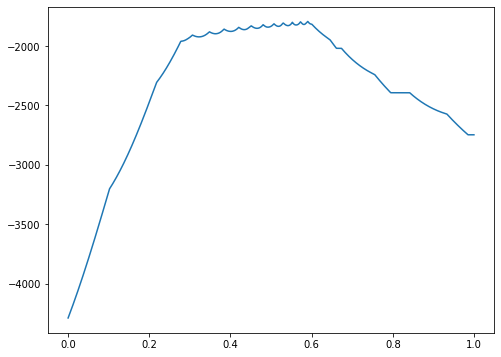

In [2]:
env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000, 0), 1.4, 0.4)
f_values = np.linspace(0, 1, 1000)
returns = [erl.do_episode_return(env, erl.FractionAgent(f)) for f in f_values]

best_f_index = np.argmax(returns)
best_f = f_values[best_f_index]
print(f"Best f = {best_f}, return = {returns[best_f_index]}")

print(f"Improvement = {returns[1] - returns[best_f_index]}")

plt.plot(f_values, returns)

This plot looks similar to the one produced by the python code (except it is flipped upside down because we are plotting returns instead of the value of `max_I`, and we chose the rewards so that the return is equal to `-max_I`.

# Runtime Benchmarking

The julia code is quite a bit faster than our old python code, but the interface between julia and python is slow. We'll only see significant speedups when the work done by julia is significantly higher than the cost of the julia-python interface. 

For example, the cost of running on episode is very small. We can roughly measure the time it takes by using `do_episodes` to run a large number of episodes and measuring the total time. Since we only call one function from julia, we use the julia-python interface only one time.

In [3]:
env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000, 0), 1.4, 0.4)
agt = erl.FractionAgent(0.55)

erl.do_episodes(env, agt, 1) # do one episode first to trigger julia's JIT compilation. 
                             # This is only needed for a fair timing comparison.

n_episodes = 10000
start = time.time()
erl.do_episodes(env, agt, n_episodes)
julia_episode_time = (time.time() - start) / n_episodes
print(f"time per episode = {julia_episode_time} seconds\n")

time per episode = 1.4964437484741211e-05 seconds



On the other hand, if we run the episodes using a python loop, then on every iteration we use the python-julia interface (instead of just once when we call `do_episodes` as we did above). This will lead to a substantially higher per-episode runtime beacuse it includes the cost of the python-julia interface in every episode, rather than only once for all 10000 episodes.

In [4]:
env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000, 0), 1.4, 0.4)
agt = erl.FractionAgent(0.55)
n_episodes = 10000
start = time.time()
[erl.do_episode_return(env, agt) for i in range(n_episodes)]
python_episode_time = (time.time() - start) / n_episodes
print(f"time per episode = {python_episode_time} seconds ({python_episode_time / julia_episode_time:.2f}x slower)\n")

time per episode = 0.00042190632820129394 seconds (28.19x slower)



When I run the above cells, the python list comprehension is roughly 50 times slower than the julia code. 

As an aside, running a similar experiment using the old python code gets a time of approximately 0.0002 seconds per episode, which is actually faster than the python list comprehension that calls `do_episode_return`. This tells us that the python-julia interface is actually expensive enough that running a single episode at a time from python is slower than just implementing the `FractionAgent` and `SIRQEnvironment` in python. For more complicated agents (e.g., ones that do some kind of learning) the cost of the python-julia interface will quickly become smaller than the time it takes to run an episode. Once this happens, the julia code should be significantly faster than the python code (even if we run single episodes from python).

# First Steps with Policy Gradient Algorithms

Next, we'll do some experiments with a simple "policy gradient" learning algorithm called REINFORCE due to Williams (1992, https://link.springer.com/content/pdf/10.1007/BF00992696.pdf). A parameterized policy is one that has parameters or "knobs" that we can adjust to change the way it behaves. For example, we can think of the fraction used by the `FractionAgent` as a parameter of its policy. The high level idea of policy gradient algorithms is to try to make small adjustments to a policy's parameters in order to gradually improve performance, measured in terms of the total reward in an episode. This is an instance of a more general algorithm called Gradient Ascent, where we try to maximize the value of a function $f$ by taking small steps "uphill" on the function's graph.

One quirk of the REINFORCE algorithm is that it only works for policies that are randomized in the sense that they randomly choose actions from some distribution. To accomodate this, we'll need to use a slight modification of the fractional quarantine policy we've experimented so far (since this policy determinstically chooses to quarantine some fixed fraction of the infected population). 

## Logit-normal Policy

We'll work with a single-parameter policy family that randomly chooses a fraction $f$ of the infected population to quarantine on each round. The fraction $f$ will be sampled from a Logit-normal distribution (https://en.wikipedia.org/wiki/Logit-normal_distribution) where the $\sigma$ parameter is fixed at 0.05 and the $\mu$ parameter is what we will vary. Roughly speaking, the $\sigma$ parameter controls how concentrated the fraction distribution will be, and $\mu$ controls the average fraction we will sample. Varying the $\mu$ parameter will have a similar effect as varying the $f$ parameter of the `FractionAgent`. 

To simplify the implementation, we implement a class `LogitNormalPolicy` that outputs real-valued actions in the interval `[0,1]` drawn from a Logit-normal distribution. We then use the `ActionTransformer` agent to convert these fractions into the number of quarantines to be applied.

Let's start by taking a look at some examples of how the action distribution looks for a few parameters for the policy. Each plot shows the probability density function for the fraction of infected individuals to quarantine for a different value of the $\mu$ parameter.

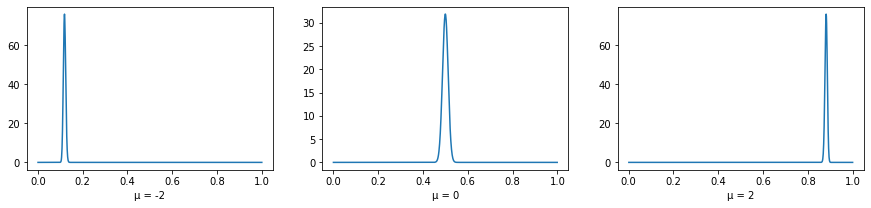

In [5]:
def plot_action_distribution(policy, state, mu):
    actions = np.linspace(0, 1, 1000)
    params = np.array([mu])
    probs = [erl.action_prob(policy, params, state, a) for a in actions]
    plt.plot(actions, probs)
    plt.xlabel(f"μ = {mu}")

# Now we'll call the above function for a few values of the parameter mu
state = erl.SIRQState(9000, 1000, 0, 2000)
policy = erl.LogitNormalPolicy(erl.ConstantFeatureExtractor(), 0.05) # the constructor for LogitNormalFractionPolicy takes the fixed value of sigma

mu_values = [-2, 0, 2]
plt.figure(figsize=(15,3))
for ix,mu in enumerate(mu_values):
    plt.subplot(1, len(mu_values), ix+1)
    plot_action_distribution(policy, state, mu)

Each of these plots shows the probability density function for the policy's action for some choice of the $\mu$ parameter in a state where there are 1000 infected individuals. We see that when $\mu = 0$ the action distribution quarantines puts most of its probability mass close to quarantining 50% of the population, while $\mu = -2$ or $\mu = 2$ quarantine closer to 10% and 90% of the population, respectively.

### LogitNormalPolicy Parameter Study

Next, let's do an brute-force parameter study similar to the one we did for the `FractionAgent` to determine what the best values of $\mu$ are. One complication is that, since the `LogitNormalPolicy` chooses a random number of individuals to quarantine on each round, the return we get from it is also random. We'll instead measure the average performance of the policy over 1000 runs.

CPU times: user 24.4 s, sys: 0 ns, total: 24.4 s
Wall time: 24.3 s
Best mu = 0.29729729729729737, return = -1804.0979573764027


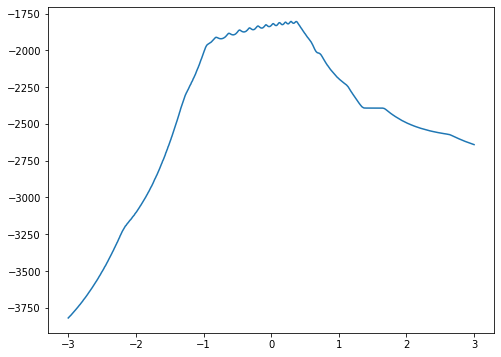

In [6]:
def evaluate_mu(env, mu):
    policy = erl.LogitNormalPolicy(erl.ConstantFeatureExtractor(), 0.05)
    agt_f = erl.NonLearningAgent(policy, np.array([mu]))
    agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)
    avg_return = np.mean(erl.do_episodes(env, agt_Q, 1000))
    return avg_return

env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000), 1.4, 0.4)
mu_values = np.linspace(-3, 3, 1000)
%time avg_returns = [evaluate_mu(env, mu) for mu in mu_values]

# Find the best value of mu
best_mu_index = np.argmax(avg_returns)
best_mu = mu_values[best_mu_index]
print(f"Best mu = {best_mu}, return = {avg_returns[best_mu_index]}")

# Plot the average return as a function of mu
plt.plot(mu_values, avg_returns)

The plot looks similar to the parameter study we did for the `FractionAgent`, except the scale of the x-axis is different and the peaks are slightly more rounded. This makes sense, since the `agt_Q` agent is a randomized version of the `FractionAgent` and the $\mu$ parameter has a slightly different meaning.

The best value of $\mu$ is $0.297$ and achieves an average maximum number of infections of 1804. This is consistent with our parameter study that we did on the `FractionAgent`: setting $\mu = 0.297$ will attempt to quarantine on average a little over 50% of the infected population (recall that $\mu=0$ corresponded to quarantining 50% of the infected population), and the average max number of infections for this policy is only about 12 higher than for the fraction agent. The reason we are doing a bit worse is likely due to the small amount of randomness in the policy on every round.

### Learning with REINFORCE

The REINFORCE algorithm tries to find optimal parameters for a policy by "walking up hill" on the plot of return vs parameter (i.e., what we plotted in the parameter study above). However, instead of estimating the return for all parameters, it tries to estimate the uphill direction by interacting with the environment.

To construct an instance of the REINFORCE algorithm, we need to tell it the types of the states and actions that the learner will encounter (in this case, the state type is `erl.SIRQState` and the actions are `Base.Float64`, julia's floating point type), as well as provide it with a policy and an "optimizer". There are two optimizers implemented: `erl.GradientAscent` and `erl.Adam`. We'll us `erl.Adam` since it is easier to work with (tuning the "stepsize" of regular gradient ascent can require a lot of experimentation).

The following cell creates a "learning curve", which plots the agent's return after $T$ episodes of experience. If the agent is learning to improve the policy, we should expect the return to grow with $T$. Since a single run of the agent can be noisy (i.e., due to randomness in the agent's actions, their performance after $T$ rounds is random), we do 50 runs of the experiment and plot the average return after $T$ episodes.

In [20]:
# Create the policy that we'll use for learning
policy = erl.LogitNormalPolicy(erl.ConstantFeatureExtractor(), 0.05)
# Initialize the optimizer. The array we pass in is the initial value of the parameter mu
optimizer = erl.Adam(np.array([-2.0]))
# Create the Reinforce agent. We pass in the state type, action type, policy, and optimizer
agt_f = erl.ReinforceAgent(erl.SIRQState, Base.Float64, policy, optimizer)
# Finally, create an agent that uses the action transformer to convert the fraction f into a number of quarantines
agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)
# Call the `erl.learning_curve` function to produce a learning curve over 15,000 episodes aveaged on 50 runs.
%time lc = erl.learning_curve(env, agt_Q, 15000, 50)

CPU times: user 50.1 s, sys: 141 ms, total: 50.2 s
Wall time: 49.8 s


Text(0, 0.5, 'Avg. Return')

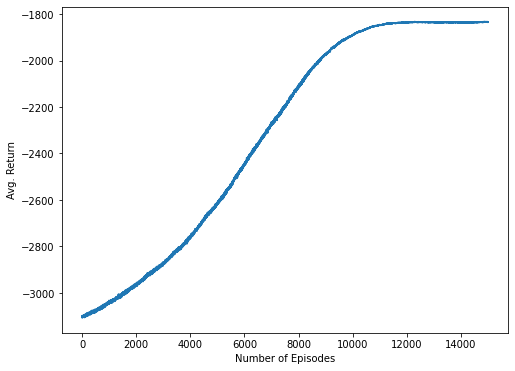

In [21]:
plt.plot(lc)
plt.xlabel("Number of Episodes")
plt.ylabel("Avg. Return")

Finally, let's compare the average performance after 15000 episodes of the reinforce agent to the values we found in the parameter study by superimposing a horizontal line showing the average reward on episode 15000 onto our parameter study plot. We see that the agent is performing nearly as well as the best parameter in hindsight after 15000 episodes of experience.

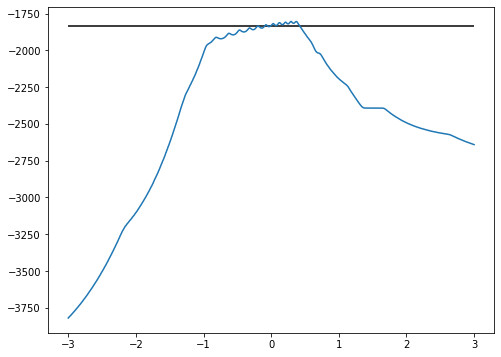

In [23]:
plt.plot(mu_values, avg_returns)
plt.hlines([lc[-1]], -3, 3)

CPU times: user 1min 21s, sys: 494 ms, total: 1min 21s
Wall time: 1min 20s


Text(0, 0.5, 'Avg. Return')

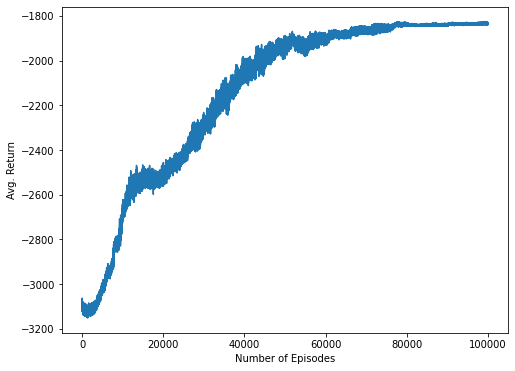

In [40]:
# Create a tile coding feature extractor
feature_extractor = erl.SIRQTileCoder(1, 10, 10, 1, 1)
# Create the policy that we'll use for learning
policy = erl.LogitNormalPolicy(feature_extractor, 0.05)
# Initialize the optimizer. The array we pass in is the initial value of the parameter mu
optimizer = erl.Adam(-2*np.ones(erl.num_features(feature_extractor)))
# Create the Reinforce agent. We pass in the state type, action type, policy, and optimizer
agt_f = erl.ReinforceAgent(erl.SIRQState, Base.Float64, policy, optimizer)
# Finally, create an agent that uses the action transformer to convert the fraction f into a number of quarantines
agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)
# Call the `erl.learning_curve` function to produce a learning curve over 100,000 episodes aveaged on 50 runs.
%time lc = erl.learning_curve(env, agt_Q, 100000, 5)

plt.plot(lc)
plt.xlabel("Number of Episodes")
plt.ylabel("Avg. Return")